<a href="https://colab.research.google.com/github/elhamod/BA820/blob/main/Clustering/Bank_Transaction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course: BA820 - Unsupervised and Unstructured ML**

**Notebook created by: Mohannad Elhamod**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import pandas as pd
import datetime

#Analyzing Bank Transactions

As a data analyst at a bank, you are given the following dataset to better understand the bank's client behavior and extract insights and interesting observations.

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "bank_transactions.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shivamb/bank-customer-segmentation",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Take a random subset. (How do you know X% is enough?)
df = df.sample(frac=0.1, random_state=42)

display(df)

100%|██████████| 24.2M/24.2M [00:00<00:00, 61.7MB/s]

Extracting zip of bank_transactions.csv...


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
892845,T892846,C5725279,8/9/84,M,JASPUR,84447.82,7/9/16,183210,11858.0
444994,T444995,C4588538,2/1/94,M,GURGAON,12549.49,16/8/16,161300,250.0
614896,T614897,C2416476,14/11/90,M,NEW DELHI,33607.65,26/8/16,102007,3360.0
457036,T457037,C5940151,15/9/90,M,HYDERABAD,38238.86,21/8/16,110438,250.0
997441,T997442,C5922989,27/11/88,M,PURBO MEDINIPUR,9506.85,14/9/16,90810,33.0
...,...,...,...,...,...,...,...,...,...
893532,T893533,C5329328,3/8/81,F,NEW DELHI,24720.52,7/9/16,161126,1200.0
667265,T667266,C4640853,15/4/89,M,DELHI,3033.73,31/8/16,81403,100.0
450371,T450372,C5035929,25/6/87,F,UDUPI,511.91,16/8/16,174740,627.0
427874,T427875,C3924762,10/9/79,F,KALWA KALWA THANE,28648.28,17/8/16,212547,1500.0


In [4]:
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046290e+05,104857.000000,104857.000000
mean,1.154616e+05,157072.778279,1600.546295
std,8.709730e+05,51399.599862,6285.266776
min,0.000000e+00,1.000000,0.000000
25%,4.740200e+03,124049.000000,165.000000
50%,1.682998e+04,164302.000000,463.000000
75%,5.745586e+04,200043.000000,1200.000000
max,1.150355e+08,235958.000000,600008.320000


##Preprocessing

If we are to perform behavioral segmentation, preprocessing ay include questions such as:
- Which features are useful to the task?
- Any transformations needed?
- Are all values valid?

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104857 entries, 892845 to 1042883
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   TransactionID            104857 non-null  object 
 1   CustomerID               104857 non-null  object 
 2   CustomerDOB              104513 non-null  object 
 3   CustGender               104751 non-null  object 
 4   CustLocation             104847 non-null  object 
 5   CustAccountBalance       104629 non-null  float64
 6   TransactionDate          104857 non-null  object 
 7   TransactionTime          104857 non-null  int64  
 8   TransactionAmount (INR)  104857 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 8.0+ MB


In [6]:
# Remove null values
df = df.dropna()

In [7]:
df_numeric = df.select_dtypes(include=['number'])

# convert df customerDoB to numbers
df_numeric['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

# dates between 1960s and 2025'
df_numeric = df_numeric[
    (df_numeric['CustomerDOB'] >= '1960-01-01') &
    (df_numeric['CustomerDOB'] <= '2026-01-01')
]

df_numeric['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df_numeric = df_numeric[
    (df_numeric['TransactionDate'] >= '1960-01-01') &
    (df_numeric['TransactionDate'] <= '2026-01-01')
]

df_numeric['TransactionTime'] = pd.to_datetime(
    df_numeric['TransactionTime'].astype(str).str.zfill(6),
    format="%H%M%S"
)

# convert CustomerDOB to age in years
df_numeric['CustomerAge'] = ((df_numeric['TransactionDate'] - df_numeric['CustomerDOB']).dt.days / 365.25).astype(int)
df_numeric.drop('CustomerDOB', axis=1, inplace=True)


display(df_numeric)

/tmp/ipython-input-438715825.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_numeric['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])
/tmp/ipython-input-438715825.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_numeric['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


,CustAccountBalance,TransactionTime,TransactionAmount (INR),TransactionDate,CustomerAge
892845,84447.82,1900-01-01 18:32:10,11858.0,2016-07-09,31
444994,12549.49,1900-01-01 16:13:00,250.0,2016-08-16,22
614896,33607.65,1900-01-01 10:20:07,3360.0,2016-08-26,25
457036,38238.86,1900-01-01 11:04:38,250.0,2016-08-21,25
997441,9506.85,1900-01-01 09:08:10,33.0,2016-09-14,27
...,...,...,...,...,...
893532,24720.52,1900-01-01 16:11:26,1200.0,2016-07-09,35
667265,3033.73,1900-01-01 08:14:03,100.0,2016-08-31,27
450371,511.91,1900-01-01 17:47:40,627.0,2016-08-16,29
427874,28648.28,1900-01-01 21:25:47,1500.0,2016-08-17,36


In [8]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86615 entries, 892845 to 1042883
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CustAccountBalance       86615 non-null  float64       
 1   TransactionTime          86615 non-null  datetime64[ns]
 2   TransactionAmount (INR)  86615 non-null  float64       
 3   TransactionDate          86615 non-null  datetime64[ns]
 4   CustomerAge              86615 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 4.0 MB


<Axes: >

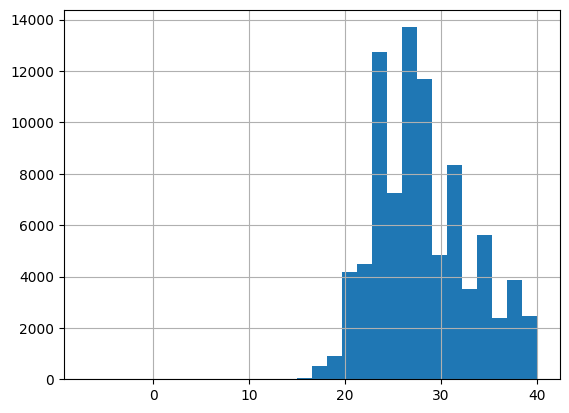

In [12]:
# Plot histogram of CustAccountBalance
df_numeric['CustomerAge'].hist(bins=30)

Normalize

In [13]:
# Normalizing the numeric features
from sklearn.preprocessing import StandardScaler

df_numeric_normalized = df_numeric.copy()
df_numeric_normalized['TransactionDate'] = df_numeric_normalized['TransactionDate'].astype('int64')
df_numeric_normalized['TransactionTime'] = df_numeric_normalized['TransactionTime'].astype('int64')
# for col in ['TransactionTime', 'TransactionDate']:
#   df_numeric_normalized[col] = df_numeric_normalized[col].astype('int64')

scaler = StandardScaler()
df_numeric_normalized = pd.DataFrame(scaler.fit_transform(df_numeric_normalized), columns=df_numeric_normalized.columns)

display(df_numeric_normalized)

,CustAccountBalance,TransactionTime,TransactionAmount (INR),TransactionDate,CustomerAge
0,0.026910,0.496780,2.125382,-0.198958,0.576689
1,-0.184065,0.051153,-0.205322,0.261120,-1.219087
2,-0.122273,-1.078819,0.419117,0.382193,-0.620495
3,-0.108683,-0.936272,-0.205322,0.321656,-0.620495
4,-0.192993,-1.309211,-0.248892,0.612231,-0.221434
...,...,...,...,...,...
86610,-0.148351,0.046136,-0.014577,-0.198958,1.374811
86611,-0.211988,-1.482499,-0.235440,0.442729,-0.221434
86612,-0.219388,0.354286,-0.129627,0.261120,0.177628
86613,-0.136826,1.052720,0.045658,0.273227,1.574342


In [14]:
df_numeric_normalized.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR),TransactionDate,CustomerAge
count,8.661500e+04,8.661500e+04,8.661500e+04,8.661500e+04,8.661500e+04
mean,-4.922076e-19,4.090896e-12,-5.742422e-18,-1.769191e-14,-2.884337e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-2.208897e-01,-3.064449e+00,-2.555184e-01,-2.414595e+00,-7.005476e+00
25%,-2.086861e-01,-6.231052e-01,-2.266054e-01,-5.621770e-01,-8.200257e-01
50%,-1.789091e-01,1.708051e-01,-1.766101e-01,3.095489e-01,-2.214337e-01
75%,-8.844608e-02,7.956706e-01,-5.473408e-02,5.516950e-01,7.762195e-01
max,8.188112e+01,1.546432e+00,1.202167e+02,1.653460e+00,2.372465e+00


##Questions:

###Q1. What distinct *customer segments* naturally emerge within the dataset? What meaningful behavioral and demographic characteristics would you include in such an analysis?

###Q2. For each identified customer segment, summarize the key insight that distinguishes the segment and propose a concrete action the bank could take to create value for the business and/or the customer.

###Q3. Which customer segment, if any, exhibits unusual or atypical behavior relative to the rest of the customer base, and do these patterns represent a business opportunity or a potential risk? What specific actions should the bank take in response, if any?

###Q4. Which demographic factors are most informative in predicting an applicant's customer segment? How should the bank use—or deliberately avoid using—this information when designing policies?

###Q5. How can *transactions* in this dataset be meaningfully profiled using relevant transaction-level attributes, and what do these profiles reveal about operational patterns?